# query magnitude with single star model

- bianry = False

In [1]:
from speedysedfit.main import create_setup_by_parameters, get_observations
import numpy as np
object_name = 'Lan_11'

#  parallax: [1.1129, 0.0433]
parameter_limits = '-[20000, 80000]\n - [5., 6.]\n - [0.01, 1]\n - [0, 2]'

#create_setup_by_parameters(object_name, teff1=35040, teff1_err=100, logg1=5.483, logg1_err=0.023,
#                                teff2 = None, teff2_err=None, logg2=None, logg2_err=None,
#                                grids=['tmap'], ebvrange= [0, 2], radrange= [0.01, 1], 
#                                variables = ['teff', 'logg', 'ebv'],
#                                parameter_limits = None,
#                                binary=False, parallax=True, direout='./LAN11')

In [2]:
variables = ['teff', 'ebv']
variables_ = ''
for _ in variables:
    variables_ += f' {_}'
variables_

' teff ebv'

In [3]:
%config InlineBackend.figure_format='retina'
import numpy as np
from astropy.io import fits
from astropy import units, constants
import reproject
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import joblib
plt.style.use('lijiaostyle')

# add SWIFT.UVM2 mag

# weigthed averge

Page 127: 4.2.6. TheMLE Applied to a Heteroscedastic Gaussian Likelihood

- $\mu^0 = \frac{ \sum_l^N \omega_{l}x_{l}}{\sum_l^N \omega_{l}}$

- $\sigma_{\mu} = \left( \sum_l^N\frac{1}{\sigma_l^2} \right)^{-1/2} = \left( \sum_l^N\omega_l \right)^{-1/2}$

In [9]:
def weight_averge(x, sigma):
    '''weighted averge
    parameters:
    -----------
    x [1D array] 
    sigma [1D array] sigma.shape = x.shape
    
    returns:
    ---------
    mu [float]
    mus [flat]
    '''
    w = 1./sigma**2
    wx = w*x
    sw = np.sum(w)
    mus = 1/np.sqrt(sw)
    mu = np.sum(wx)/sw
    return mu, mus

In [10]:
from speedysedfit.photometry_query import get_vizier_photometry, get_coordinate
from speedysedfit import filters
from numpy.lib.recfunctions import append_fields

In [11]:
ra, dec = get_coordinate(object_name)
photometry_ = get_vizier_photometry("{} {}".format(ra, dec))

I/350/gaiaedr3
I/345/gaia2
II/336/apass9
II/246/out
II/311/wise


/home/lijiao/anaconda3/lib/python3.8/site-packages/speedysedfit-0.1.0-py3.8.egg/speedysedfit/photometry_query.py:110: UserWarning: Warning: converting a masked element to nan.
  photometry = np.array(photometry, dtype=dtypes)


# fit sed

- fit without swift uvm2 

In [4]:
import yaml, os
from speedysedfit.main import fit_sed_parameters
setup_file = 'LAN11/Lan_11_setup_tmap.yaml'
ifile = open(setup_file)
setup = yaml.safe_load(ifile)
ifile.close()
setup['photometryfile'] = os.path.join(os.path.dirname(setup_file), setup['photometryfile']) 
processes=20

# -- obtain the observations
photbands, obs, obs_err = get_observations(setup)

# -- perform the SED fit
#results, samples, constraints, gridnames = fit_sed_parameters(setup, photbands, obs, obs_err, processes=processes)

	 APASS.B
	 APASS.V
	 APASS.G
	 APASS.R
	 APASS.I
They were removed


In [5]:
##prepare_grid

from speedysedfit.model import get_grid_file, _get_flux_from_table
from astropy.io import fits

gridname='tmap'
variables=['teff', 'logg', 'ebv']
teffrange=(20000, 50000)
loggrange=(5, 6)
ebvrange=(0, 2)

flux = []
grid_pars = []
grid_names = np.array(variables)

gridfilename = get_grid_file(integrated=True, grid=gridname)


with fits.open(gridfilename) as ff:
    # -- make an alias for further reference
    ext = ff[1]

    # -- the grid is already cut here to limit memory usage
    keep = np.ones(len(ext.data), bool)
    for name in variables:
        # -- first find the closest actuall grid points
        low, high = locals()[name + 'range']
        lidx = np.abs(ext.data.field(name)[ext.data.field(name) <= low] - low).argmin()
        hidx = np.abs(ext.data.field(name)[ext.data.field(name) >= high] - high).argmin()
        low = ext.data.field(name)[ext.data.field(name) <= low][lidx]
        high = ext.data.field(name)[ext.data.field(name) >= high][hidx]

        # -- we need to be carefull for rounding errors
        in_range = (low <= ext.data.field(name)) & (ext.data.field(name) <= high)
        on_edge = np.allclose(ext.data.field(name), low) | np.allclose(ext.data.field(name), high)

        keep = keep & (in_range | on_edge)

    grid_pars = np.vstack([ext.data.field(name)[keep] for name in variables])                                                                                         
    flux = _get_flux_from_table(ext, photbands, include_Labs=True)[keep]

flux = np.log10(flux)

In [6]:
flux.T.shape, grid_pars.shape

((12, 3280), (3, 3280))

In [7]:
flux.T[0].shape

(3280,)

In [8]:
# create_pixeltypegrid
grid_pars = np.array([[ 1. ,  1. , 0.5], [ 2. ,  1. ,  -0.5]]).T
grid_data = np.array([[ 5000. , 4.5], [ 6000 , 4.5]]).T
uniques = [np.unique(column, return_inverse=True) for column in grid_pars]
axis_values = [uniques_[0] for uniques_ in uniques]
unique_val_indices = [uniques_[1] for uniques_ in uniques]
data_dim, data_size = np.shape(grid_data)
par_dims   = [len(uv[0]) for uv in uniques]
par_dims.append(data_dim)
pixelgrid = np.ones(par_dims)

# We put np.inf as default value. If we get an inf, that means we tried to access
# a region of the pixelgrid that is not populated by the data table
pixelgrid[pixelgrid==1] = np.inf
pixelgrid1 = pixelgrid.copy()

# now populate the multiDgrid
indices = [uv[1] for uv in uniques]
pixelgrid1[indices]  = grid_data.T
indices = np.array([uv[1] for uv in uniques])
for _i in np.arange(data_size):
    pixelgrid[tuple(indices[:,_i])] = grid_data[:, _i]

#pixelgrid1[indices[0], indices[1], indices[2]]  = grid_data.T.copy()

<ipython-input-8-b6679f5dcd74>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pixelgrid1[indices]  = grid_data.T


In [9]:
#### interpol.interpolate

axis_values, pixelgrid = grids[0][0], grids[0][1]
p0_ = []
p = np.array([[24000], [5.5], [0.5]])
for av_,val in zip(axis_values,p):
      indices = np.searchsorted(av_,val)
      indices[indices==len(av_)] = len(av_)-1
      p0_.append(indices)
print(p0_)       
for i, ax in enumerate(axis_values):
      p[i] = np.array(p[i], dtype = ax.dtype)
        
p_ = np.array([np.searchsorted(av_,val) for av_, val in zip(axis_values,p)])

lowervals_stepsize = np.array([[av_[p__-1], av_[p__]-av_[p__-1]] \
                           for av_, p__ in zip(axis_values,p_)])

p_coord = (p-lowervals_stepsize[:,0])/lowervals_stepsize[:,1] + np.array(p_)-1

NameError: name 'grids' is not defined

In [143]:
from scipy import ndimage

In [79]:
from speedysedfit import interpol, filters
interpol.interpolate(np.array([[21000], [5], [0]]), grids[0][0], grids[0][1])

array([[8.18633181],
       [8.4413569 ],
       [7.80862207],
       [8.18285074],
       [8.45222637],
       [7.81520725],
       [7.07282138],
       [6.60370482],
       [6.15302272],
       [5.404397  ],
       [4.85309963],
       [2.23651304]])

In [80]:
interpol.interpolate(np.array([[20000], [5], [0]]), grids[0][0], grids[0][1])

array([[8.15230395],
       [8.4051083 ],
       [7.77901588],
       [8.14883159],
       [8.41520612],
       [7.78555436],
       [7.04868886],
       [6.58120526],
       [6.13180289],
       [5.38375501],
       [4.83245811],
       [2.15764082]])

In [12]:
pnames

['teff', 'logg', 'rad', 'ebv']

In [10]:
from speedysedfit import mcmc, model, plotting, fileio, filters, photometry_query
from speedysedfit import statfunc, model, filters
from multiprocessing import Pool
import time
import emcee
from speedysedfit.mcmc import *


pnames = setup['pnames']
limits = np.array(setup['limits'])
assert len(pnames) == len(limits), \
        f"The number of parameters fitted has to match the provided limits. Received: \n{len(pnames)} " \
        f"pnames: {pnames} \n and \n{len(limits)} limits: {limits}"

# -- pars constraints
constraints = setup['constraints']
for con, val in list(constraints.items()):
    if len(val) == 2:
        constraints[con] = [val[0], val[1], val[1]]

if 'parallax' in constraints:
    p, pm, pp = constraints.pop('parallax')
    constraints['d'] = [1000. / p, 1000. * pm / p ** 2, 1000. * pp / p ** 2]

print("Applied constraints: ")
for con, val in list(constraints.items()):
    print("\t {} = {} - {} + {}".format(con, val[0], val[1], val[2]))

if 'distance' in constraints:
    # convert pc to Rsol
    constraints['distance'] = [44365810.04823812 * constraints['distance'][0],
                               44365810.04823812 * constraints['distance'][1],
                               44365810.04823812 * constraints['distance'][2], ]

# -- pars limits on derived properties
derived_limits = setup['derived_limits']

# -- pars grid
gridnames = setup['grids']
grids = model.load_grids(gridnames, pnames, limits, photbands)

# -- switch logg to g for a binary system
if 'q' in constraints:
    if 'logg' in pnames:
        limits[pnames.index('logg')] = 10 ** limits[pnames.index('logg')]
        pnames[pnames.index('logg')] = 'g'

    if 'logg2' in pnames:
        limits[pnames.index('logg2')] = 10 ** limits[pnames.index('logg2')]
        pnames[pnames.index('logg2')] = 'g2'

    if 'logg' in constraints:
        g = 10 ** constraints['logg'][0]
        g_el = g * constraints['logg'][1] * np.log(10)
        g_eu = g * constraints['logg'][2] * np.log(10)
        constraints['g'] = [g, g_el, g_eu]

    if 'logg2' in constraints:
        g = 10 ** constraints['logg2'][0]
        g_el = g * constraints['logg2'][1] * np.log(10)
        g_eu = g * constraints['logg2'][2] * np.log(10)
        constraints['g2'] = [g, g_el, g_eu]

# -- check for variables that are kept fixed
fixed = np.where(limits[:, 0] == limits[:, 1])
varied = np.where(limits[:, 0] != limits[:, 1])

pnames = np.array(pnames)
fixed_variables = {}
for par, val in zip(pnames[fixed], limits[:, 0][fixed]):
    fixed_variables[par] = val

pnames = list(pnames[varied])
limits = limits[varied]

# -- pars mcmc setup
nwalkers = setup.get('nwalkers', 100)
nsteps = setup.get('nsteps', 2000)
nrelax = setup.get('nrelax', 500)
a = setup.get('a', 10)
colors = np.array([filters.is_color(photband) for photband in photbands], bool)
pos = [ np.random.uniform(lim[0], lim[1], nwalkers) for lim in limits]
pos = np.array(pos).T
#-- setup the sampler
ndim = len(pnames)
kwargs = {'pnames':pnames,
          'colors':colors,
          'grid':grids,
          'fixed_variables':  fixed_variables,
          'constraints':constraints,
          'derived_limits':derived_limits,
          'prop_func': statfunc.get_derived_properties}

# TODO: storing the blobs as dictionary with dtype object and then later converting to recarray is inefficient.
# This needs to be addressed: provide the correct dtypes here and let emcee directly store them in recarray
#with Pool(processes=processes) as pool:
#     print(f'processes = {processes}')
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, a=a,
#                                     args=(obs, obs_err, limits), kwargs=kwargs, blobs_dtype=[('blob','O')], pool=pool)
#
#     #================
#     # MCMC part
#
#     #-- run the sampler, both burn in and actual run in one
#     start = time.time()
#     sampler.run_mcmc(pos, nsteps+nrelax, progress=True)
#     end = time.time()
#     multi_time = end - start
#     #print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Applied constraints: 
	 teff = 35040.0 - 100.0 + 100.0
	 logg = 5.48 - 0.02 + 0.02
	 d = 872.5242125468983 - 22.07765654293696 + 22.07765654293696


In [11]:
### lnprob
pars = {}
theta = [30500, 5.48, 0.28, 0.1]
y , y_err = obs, obs_err
for name, value in zip(kwargs['pnames'], theta):
    pars[name]=value

#-- add extra variables which are not fitted to pars.
pars.update(kwargs.pop('fixed_variables', {}))
prop_func = kwargs.pop('prop_func', statfunc.get_derived_properties)
syn_drv = prop_func(**pars)
derived_properties = syn_drv
derived_limits = kwargs.pop('derived_limits', {})

model_func = kwargs.pop('model_func', model.get_itable) 
stat_func = kwargs.pop('stat_func', statfunc.stat_chi2)
kwargs.update(pars)

# lnlike
model_func = kwargs.pop('model_func', model.get_itable)
stat_func = kwargs.pop('stat_func', statfunc.stat_chi2)
colors = kwargs.get('colors', np.array([False for i in y], bool))
constraints = kwargs.pop('constraints', {})
kwargs.update(pars)
y_syn, extra_drv = model_func(**kwargs)
derived_properties.update(extra_drv)


## stat_chi2
meas, e_meas, colors, syn, pars, constraints= y, y_err, colors, y_syn, pars, constraints
nani = np.isnan(meas) | np.isnan(e_meas)
meas, e_meas, colors, syn = meas[~nani], e_meas[~nani], colors[~nani], syn[~nani]
ratio = (meas / syn)[~colors]
weights = (meas / e_meas)[~colors]
scale = np.average(ratio, weights=weights)
e_scale = np.sqrt(np.dot(weights, (ratio - scale) ** 2) / weights.sum())
chisq = np.where(colors, (syn - meas) ** 2 / e_meas ** 2, (syn * scale - meas) ** 2 / e_meas ** 2)
#derived_properties = kwargs.get('derived_properties', {})
#constraints = kwargs.get('constraints', {})
for con, (c, c_m, c_p) in list(constraints.items()):
    syn_c = None
    if con == 'd' and sum(~colors) > 0:
        # distance can only be constrained if there is at least 1 absolute measurement
        c, c_m, c_p = 1. / c ** 2, 2. * c_m / c ** 3, 2. * c_p / c ** 3
        #c, c_m, c_p = 1. /c, c_m / c**2,  c_p / c ** 2
        syn_c = scale

    elif con in pars:
        # constrained on a fitted parameter
        syn_c = pars[con]
        

    elif con in derived_properties:
        # constrained on a derived parameter
        syn_c = derived_properties[con]

    if not syn_c is None:
        print(syn_c)
        chi2_c = np.where(syn_c < c, (syn_c - c) ** 2 / c_m ** 2, (syn_c - c) ** 2 / c_p ** 2)

        # append to chisq array
        chisq = np.append(chisq, chi2_c)


30500
5.48
7.558816478290597e-22


In [14]:
derived_properties

{'mass': 0.8629957789525198, 'd': 0, 'L': array([55.79462399])}

In [21]:
derived_properties

{'mass': 0.8629957789525198, 'd': 0, 'L': array([55.79462399])}

In [51]:
_R = 1 * units.Rsun
_d = 872.5242125468983

In [52]:
y_syn * (_R.to('pc').value/_d)**2

array([1.19920254e-14, 2.14032006e-14, 5.21738744e-15, 1.19069267e-14,
       2.21266199e-14, 5.29908541e-15, 9.64289639e-16, 3.26875019e-16,
       1.14893916e-16, 2.05470203e-17, 5.80266648e-18])

In [44]:
y

array([1.34530670e-14, 2.36839628e-14, 6.00585894e-15, 1.32035124e-14,
       2.49247874e-14, 6.27165155e-15, 1.23602551e-15, 4.22600350e-16,
       1.45115211e-16, 2.38497680e-17, 6.72538764e-18])

In [120]:
_m = 10**theta[1]*units.cm/units.s**2 * (theta[2]*units.Rsun)**2/constants.G
_m.to('Msun')

<Quantity 0.86347235 solMass>

In [121]:
samples = sampler.get_chain(discard=nrelax, thin=1, flat=True)
blobs = sampler.get_blobs(discard=nrelax, thin=1, flat=True)
probabilities = sampler.get_log_prob(discard=nrelax, thin=1, flat=True)
accept = np.where(np.isfinite(probabilities))
samples = samples[accept]
blobs = blobs[accept]
probabilities = probabilities[accept]
dtypes = [(n, 'f8') for n in pnames]
samples = np.array([tuple(s) for s in samples], dtype=dtypes)
names = list(blobs[0][0].keys())
pars = []
for b in blobs:
    pars.append(tuple([b[0][n] for n in names]))
dtypes = [(n, 'f8') for n in names]
blobs = np.array(pars, dtype=dtypes)




In [29]:
data = merge_arrays((samples, blobs), asrecarray=True, flatten=True)

In [3]:
grids

NameError: name 'grids' is not defined

	 APASS.B
	 APASS.V
	 APASS.G
	 APASS.R
	 APASS.I
They were removed
Applied constraints: 
	 teff = 35040.0 - 100.0 + 100.0
	 logg = 5.48 - 0.02 + 0.02
	 d = 872.5242125468983 - 22.07765654293696 + 22.07765654293696


  0%|          | 0/1250 [00:00<?, ?it/s]

processes = 20


100%|██████████| 1250/1250 [02:00<00:00, 10.34it/s]


Multiprocessing took 121.0 seconds
['tmap']

Resulting parameter values and errors:
   Par             Best        Pc       emin       emax
   teff       =   35057     35052   -    100   +    102
   logg       =    5.48      5.48   -   0.02   +   0.02
   rad        =    0.28      0.28   -   0.01   +   0.01
   ebv        =   0.161     0.161   -  0.002   +  0.002
   mass       =    0.85      0.86   -   0.06   +   0.06
   d          =     870       875   -     22   +     23
   L          =   84.06     85.06   -   4.16   +   4.55
   scale      =   0.000     0.000   -  0.000   +  0.000
   chi2       = 138.470   141.815   -  1.937   +  3.236


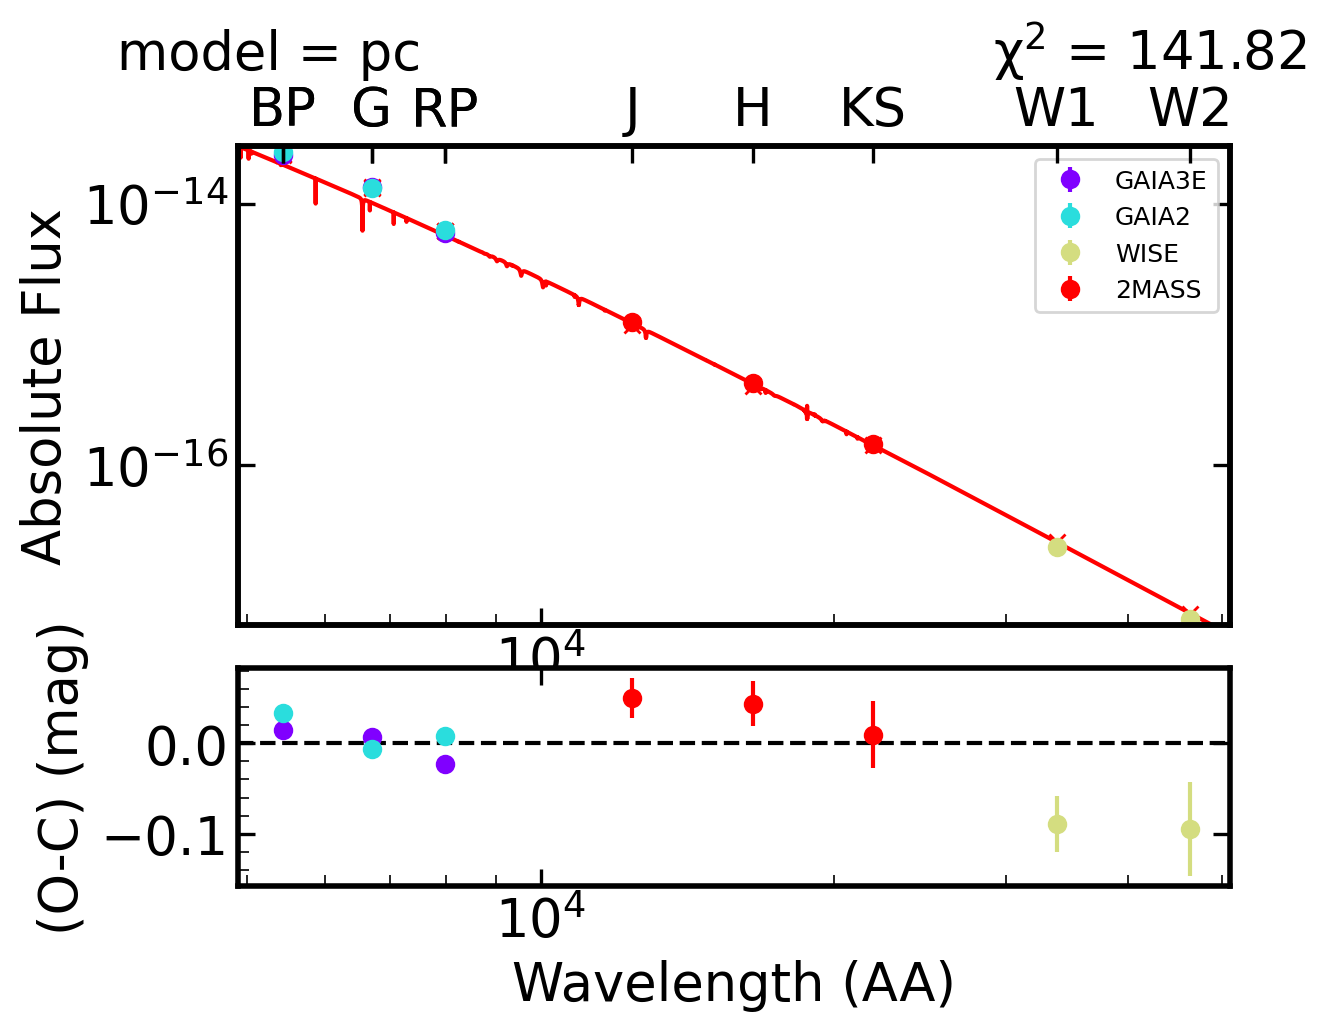

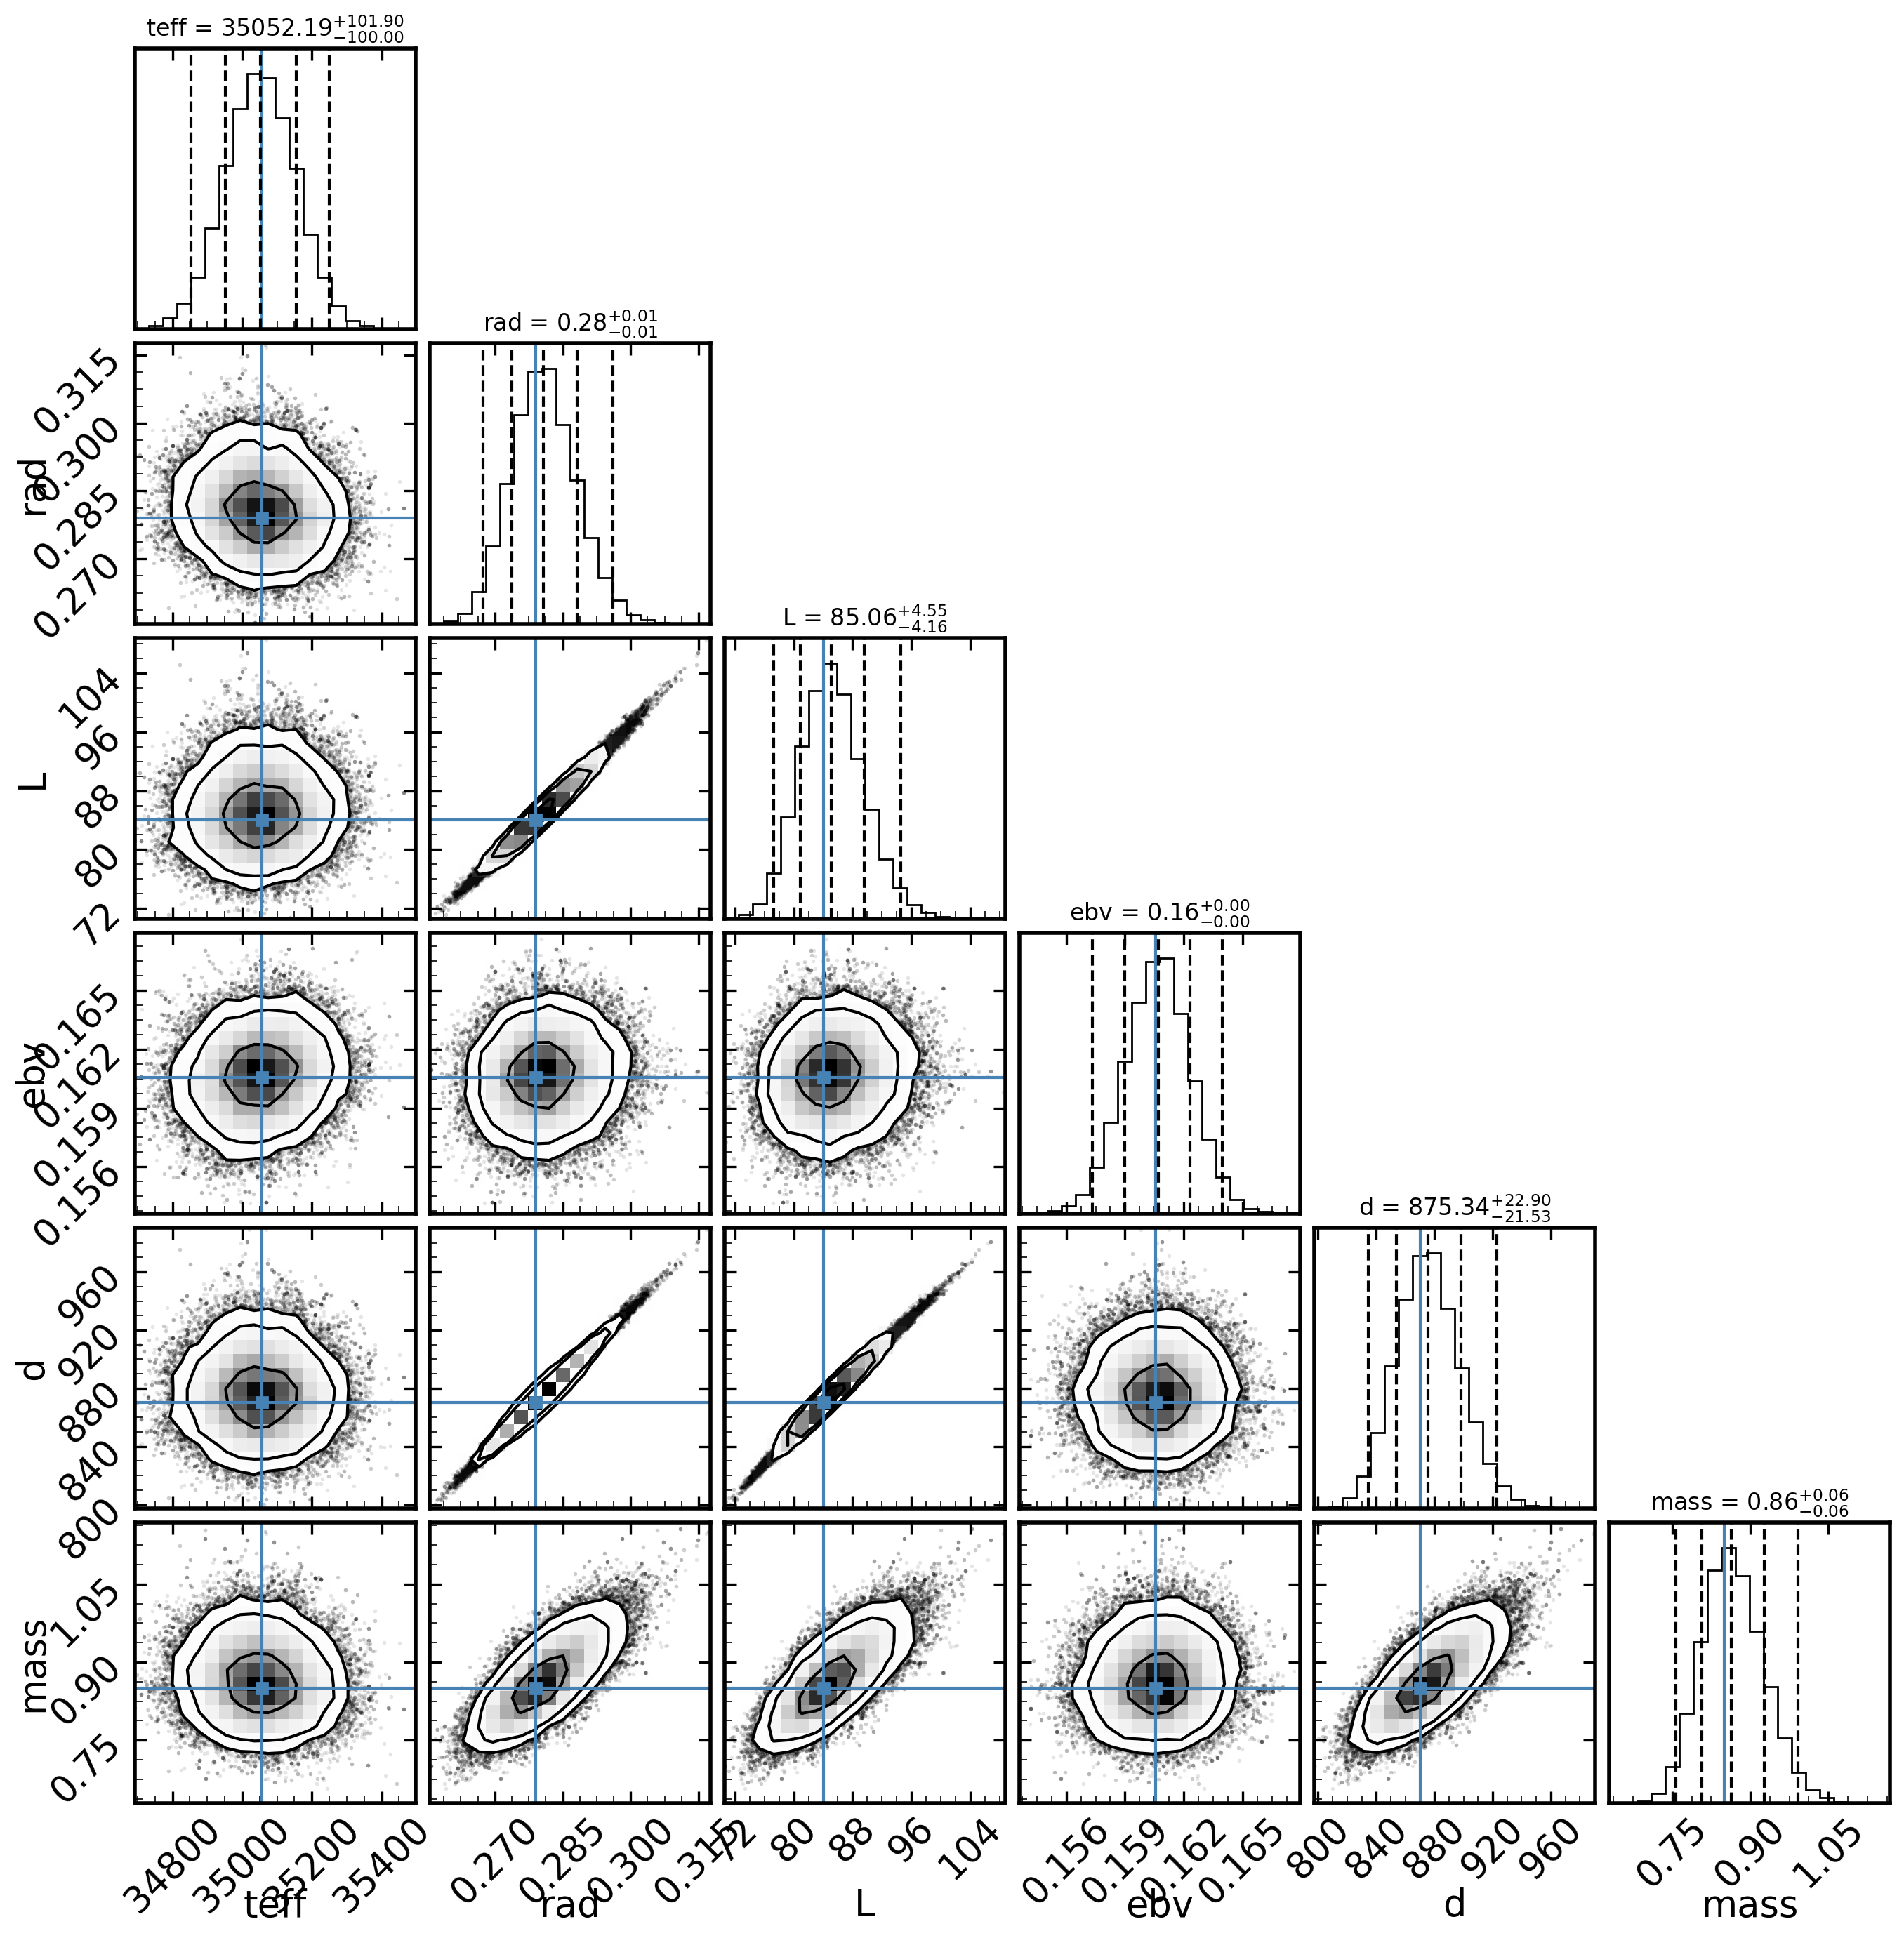

In [15]:
from speedysedfit.main import perform_fit_parameters
setup_file = 'LAN11/Lan_11_setup_tmap.yaml'
perform_fit_parameters(setup_file, processes=20, noplot=False)

# check the difference between L and $4\pi R^2 \sigma T^4$

- because L is obtained as 
  $L = \int_{\lambda_0}^{\lambda_1}{fd\lambda}$   (speedysedfit.model.luminosity --> np.trapz(flux, x=wave))
  
- for example

In [54]:
gridfile = model.get_grid_file(integrated=False, grid='tmap')
ff = fits.open(gridfile)
teffs = []
loggs = []                                     
hdus = []
for hdu in ff[1:]:
    teffs.append(float(hdu.header['TEFF']))
    loggs.append(float(hdu.header['LOGG']))
    hdus.append(hdu)

teff =  34000
_ind = np.where((np.array(teffs) == teff) & (np.array(loggs) == 5.5))[0][0]+1
data = ff[_ind].data
ff.close()
wave, flux = data['wavelength'], data['flux']
print(f'header["TEFF"] = {ff[_ind].header["TEFF"]}')
L = model.luminosity(wave, flux)

Teff = teff*units.K
R_sed = 1*units.Rsun
L_0 = 4*np.pi * R_sed**2 *constants.sigma_sb*Teff**4
L_0.to('Lsun')

print(f'L = {L}; 4\piR^2 \sigma T^4 = {L_0.to("Lsun")}')

header["TEFF"] = 34000
L = 1003.2219725532146; 4\piR^2 \sigma T^4 = 1203.9524821666341 solLum


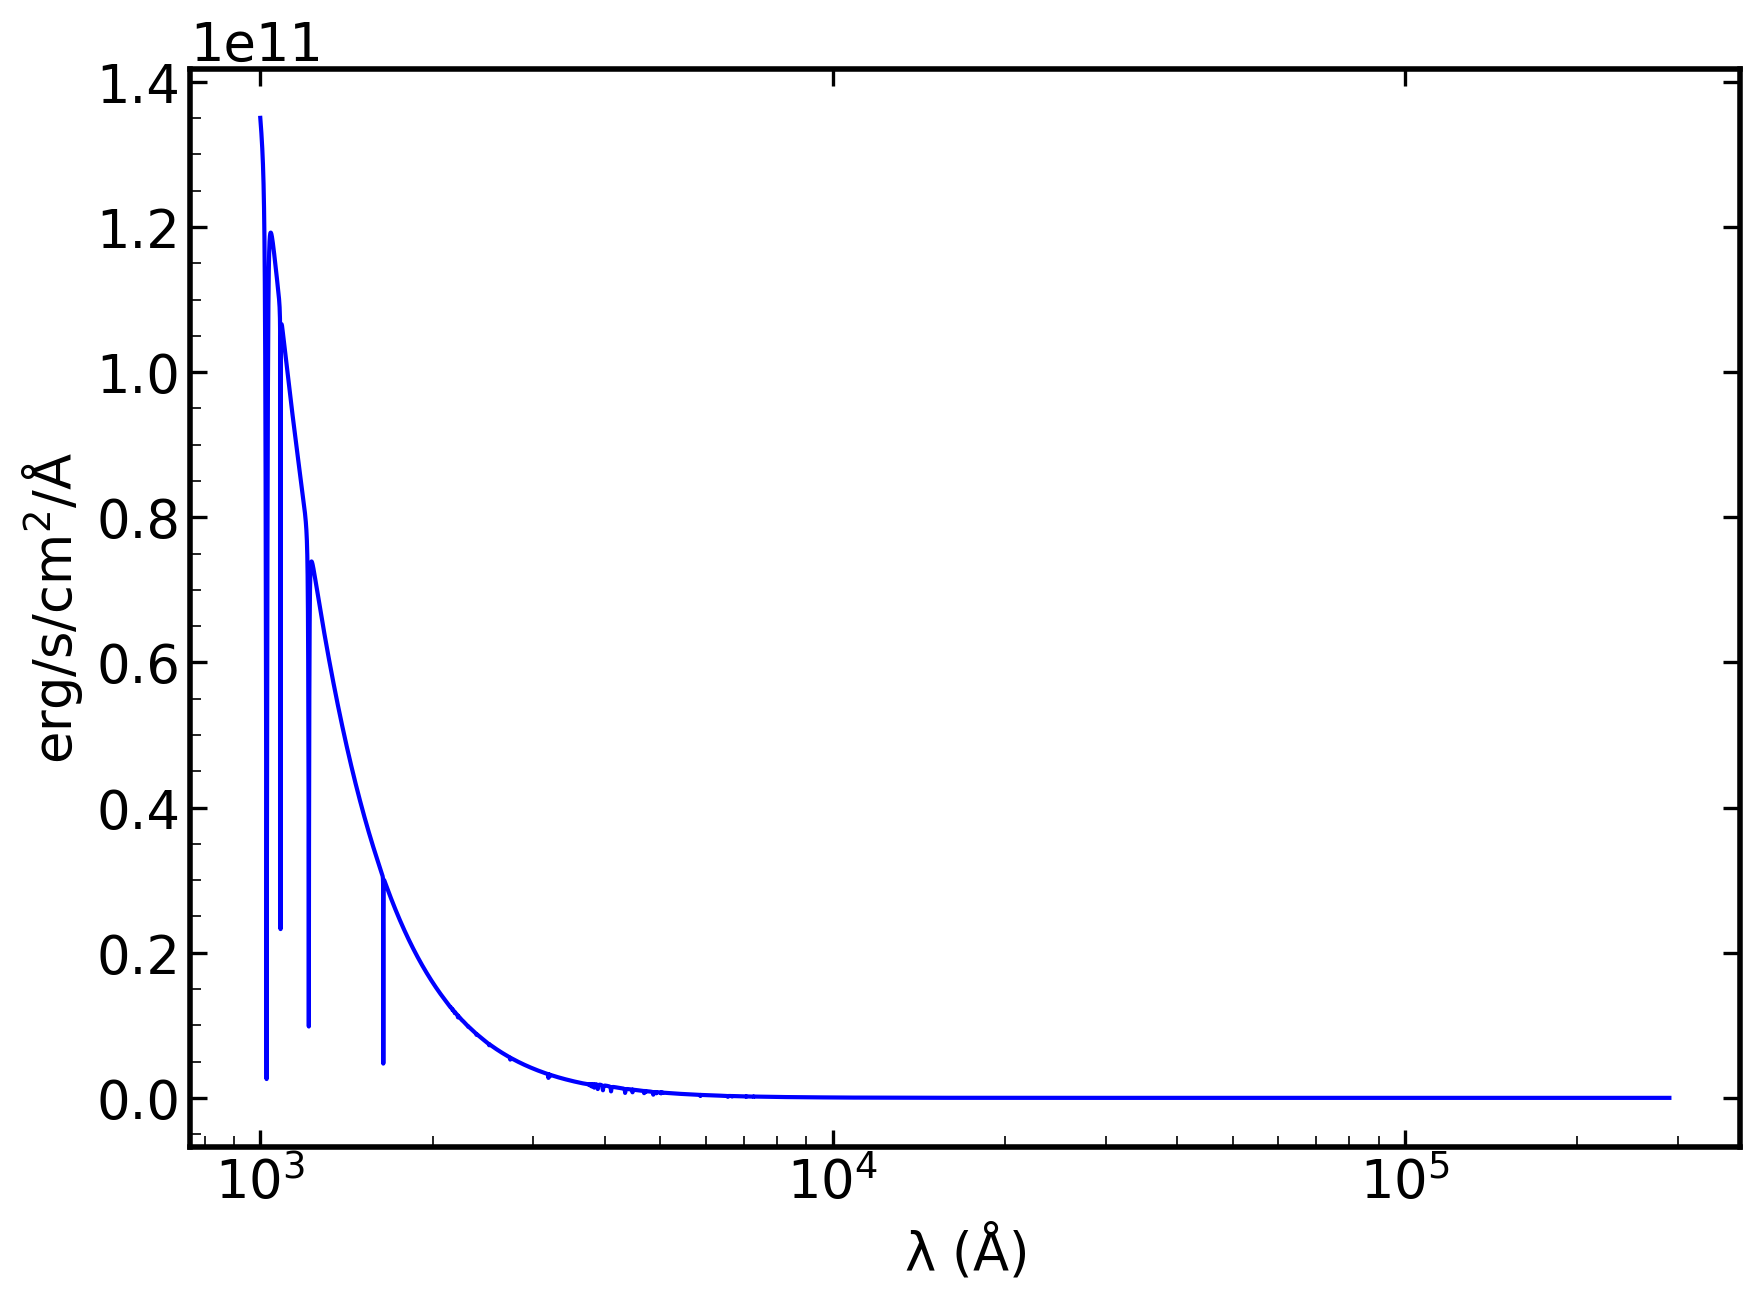

In [50]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
#data = ff[1].data
#_wave1, _flux1 = data['wavelength'], data['flux']
plt.plot(wave, flux, 'b')
#plt.plot(_wave1, _flux1, 'k')
plt.xlabel(r'$\lambda$ $(\AA)$')
plt.ylabel(r'$erg/s/cm^2/\AA$')
plt.semilogx()
plt.show()

In [61]:
from speedysedfit.model import get_grid_file 
gridname = get_grid_file(integrated=True, grid='tmap')
gd = fits.open(gridname)
_ind = (gd[1].data['teff'] == teff) & (gd[1].data['ebv'] == 0)
_Labs = gd[1].data[_ind]['Labs']
gd.close()
_Labs

array([ 941.24220457,  963.91323908,  980.74650786,  993.28570602,
       1003.22197255, 1011.042099  , 1017.09503152, 1022.30482749,
       1026.56736965])

In [62]:
np.sqrt(0.0322**2 + 0.029**2)

0.043334051276103874

In [252]:
85/105

0.8095238095238095

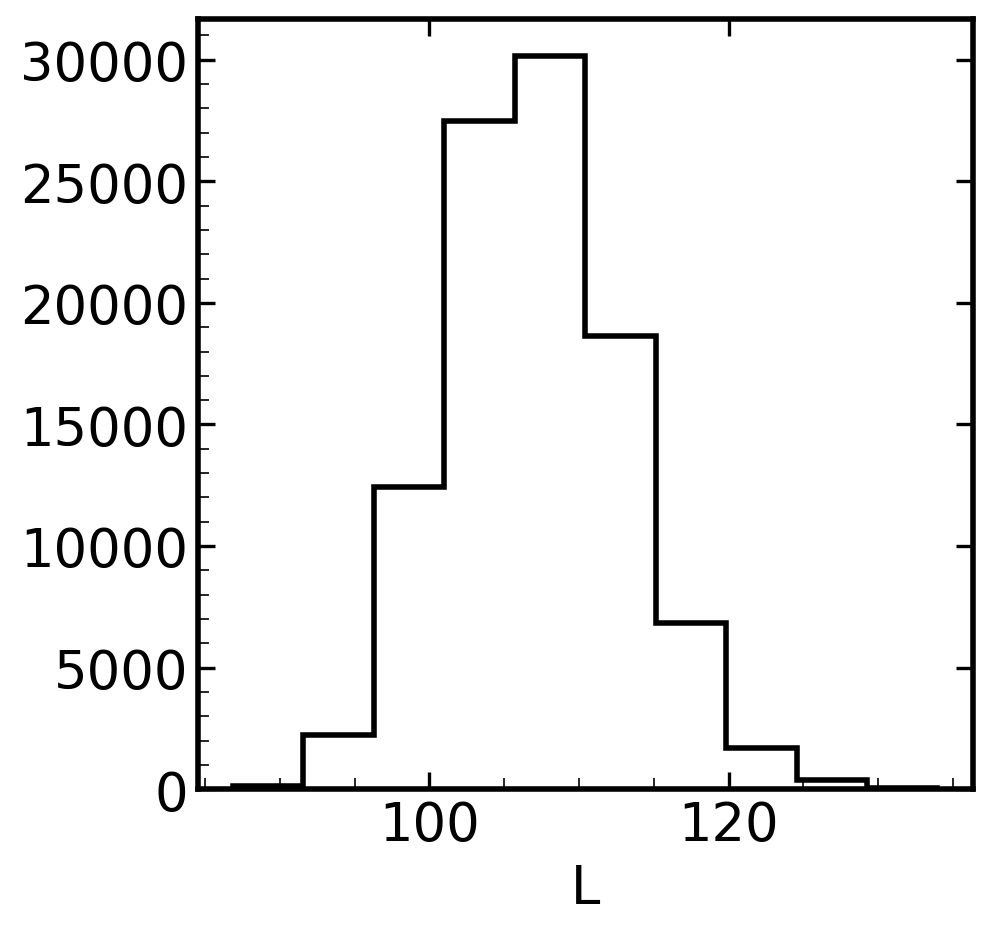

In [250]:
Teff = samples['teff']*units.K
R_sed = samples['rad']*units.Rsun
L = 4*np.pi * R_sed**2 *constants.sigma_sb*Teff**4
L.to('Lsun')
fig,ax = plt.subplots(1,1, figsize=(5,5))
bins = np.arange(80, 110, 1)
plt.hist(L.to('Lsun').value, histtype='step', lw=2, color='k')
plt.xlabel(r'L')
plt.show()

In [10]:
from astropy import units, constants

In [51]:
P_LAN = 0.15218 *units.day 
R_sed = samples['rad']*units.Rsun

def RP2vsini(P, R, incl = 90):
    '''
    return vsini
    '''
    vsini = 2*np.pi*R/P*np.sin(np.deg2rad(incl))
    return vsini.to('km/s')

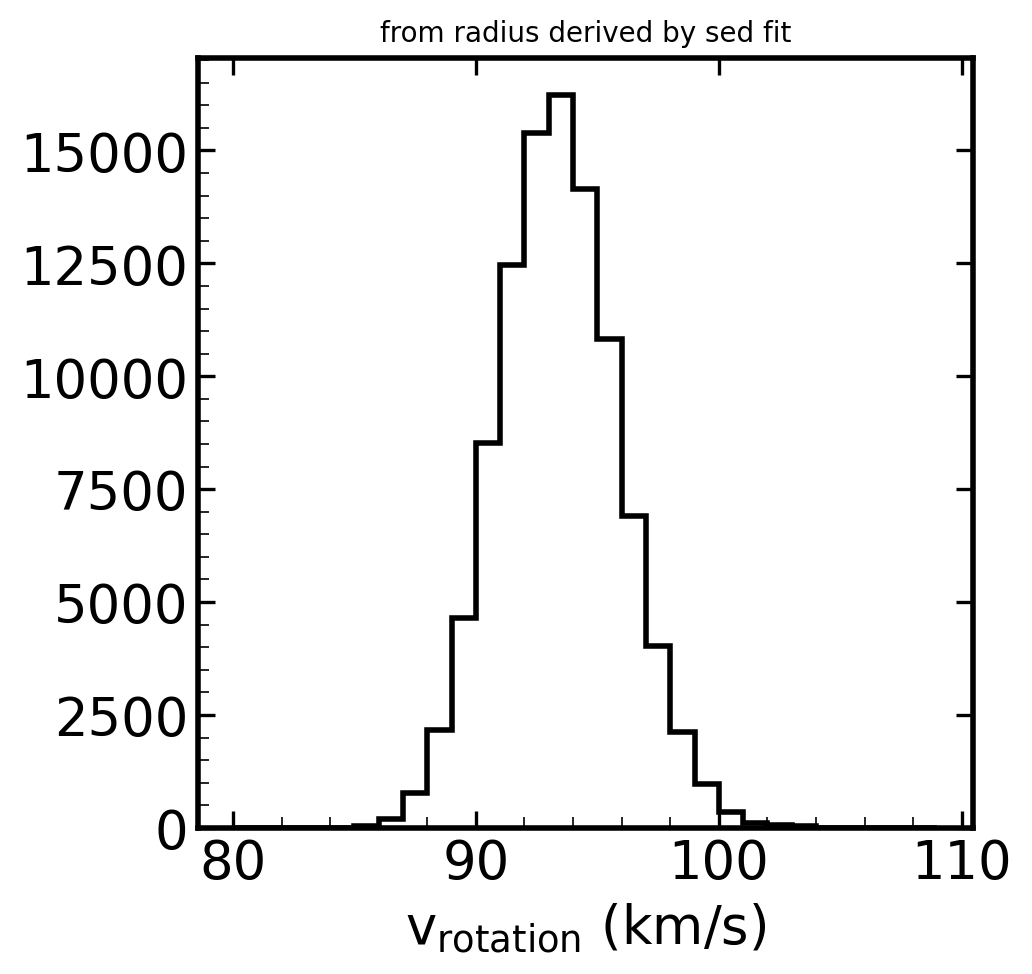

In [73]:
vsini_sed = RP2vsini(P_LAN, R_sed, incl=90)


fig,ax = plt.subplots(1,1, figsize=(5,5))
bins = np.arange(80, 110, 1)
plt.hist(vsini_sed.value, histtype='step',bins=bins, lw=2, color='k')
plt.xlabel(r'$v_{rotation} $ (km/s)')
plt.title('from radius derived by sed fit', fontsize=10)
plt.show()

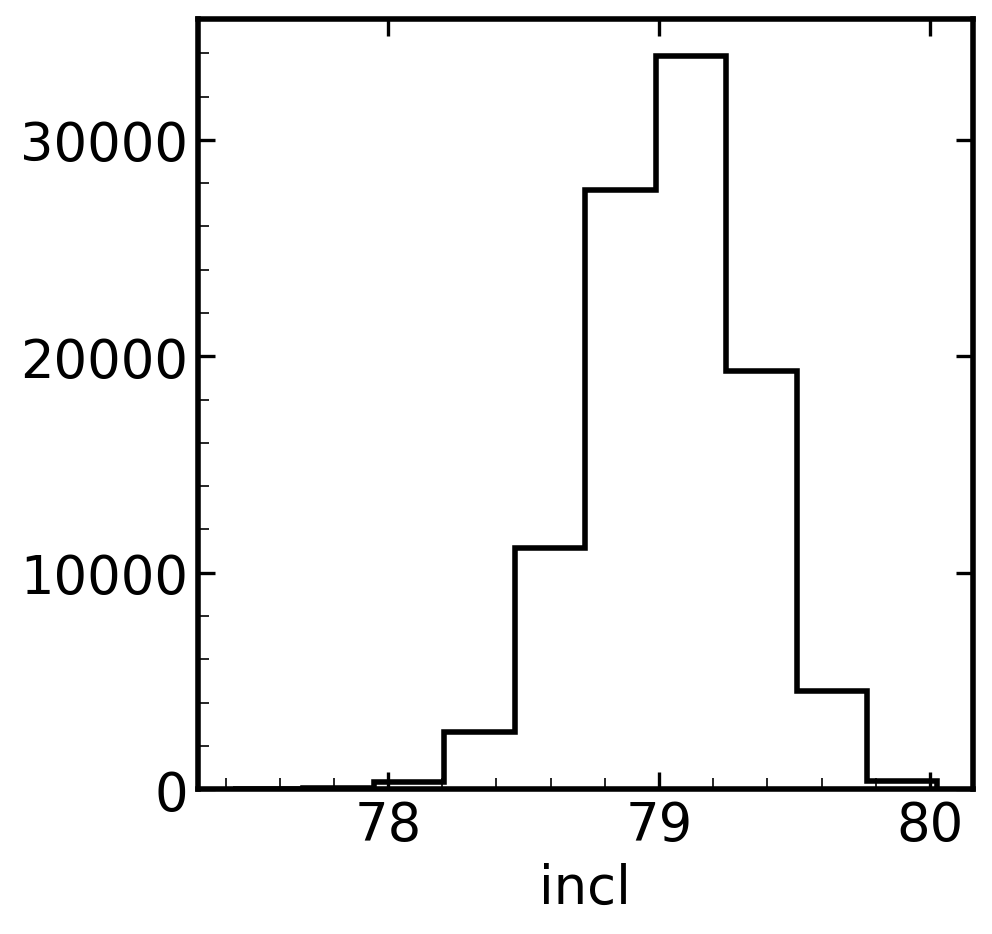

In [91]:
def m1m2ptosmi(m1, m2, P):
    n = 2*np.pi/P
    a = (constants.G*(m1+m2)/n**2)**(1./3.)
    return a.to('Rsun')
    
a = m1m2ptosmi(0.87*units.Msun, 1*units.Msun, P_LAN)

cosi = R_sed.to('Rsun')/a.to('Rsun')
incl = np.rad2deg(np.arccos(cosi))

fig,ax = plt.subplots(1,1, figsize=(5,5))
bins = np.arange(80, 110, 1)
plt.hist(incl.value, histtype='step', lw=2, color='k')
plt.xlabel(r'incl')
#plt.title('i=90, from radius derived by sed fit', fontsize=10)
plt.show()

- $f = \frac{M^3_2\sin^3i}{(M_1+M_2)^2} = \frac{P_{\rm orb} K_1^3}{2\pi G}$

In [80]:
def binaryfunc(P, K1):
    '''
    return f (in units of Msun)
    '''
    f = P*K1**3/2/np.pi/constants.G
    f.to('Msun')
    return f

f = binaryfunc(P_LAN, 200*units.km/units.s, sini)


def m1ftom2(m1, f, incl=90):
    sini = np.sin(np.rad2deg(incl))
    sini3 = sini**3
    

<Quantity 2.90309986e+15 d kg km3 / (m3 s)>

- fit with swift uvm2